In [1]:
# leaf_classification_4.ipynb
# ==============================================
# This notebook demonstrates classification using a combination of complementary features:
# - Color Histogram (HSV)
# - Local Binary Patterns (LBP)
# - Histogram of Oriented Gradients (HOG)
# - ANN and CNN classifiers added for deeper learning

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os                        # For file and directory operations
import cv2                       # OpenCV for image I/O and processing
import numpy as np               # NumPy for numerical operations
import matplotlib.pyplot as plt  # For visualization
from skimage.feature import local_binary_pattern      # LBP texture feature
from skimage.feature import hog                       # HOG feature extraction
from sklearn.model_selection import train_test_split  # To split data into train/test
from sklearn.preprocessing import StandardScaler      # For feature normalization
from sklearn.neighbors import KNeighborsClassifier    # k-NN classifier
from sklearn.tree import DecisionTreeClassifier       # Decision Tree classifier
from sklearn.metrics import classification_report, confusion_matrix  # For evaluation
from sklearn.preprocessing import LabelEncoder        # To encode labels

# For ANN
from sklearn.neural_network import MLPClassifier

# For CNN
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array

In [4]:
# 1. We in the start define dataset path and class names
base_dir = '/content/drive/MyDrive/archive/train/train'
class_names = [d for d in sorted(os.listdir(base_dir)) if os.path.isdir(os.path.join(base_dir, d))]

In [5]:
# 2. Defining feature extraction functions

def extract_color_histogram(image, bins=(8, 8, 8)):
    """
    Extract HSV color histogram features from an image.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)  # Convert BGR to HSV color space
    # Compute histograms for H, S, and V channels
    h_hist = cv2.calcHist([hsv], [0], None, [bins[0]], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [bins[1]], [0, 256])
    v_hist = cv2.calcHist([hsv], [2], None, [bins[2]], [0, 256])
    # Normalize and flatten
    h_hist = cv2.normalize(h_hist, h_hist).flatten()
    s_hist = cv2.normalize(s_hist, s_hist).flatten()
    v_hist = cv2.normalize(v_hist, v_hist).flatten()
    return np.hstack([h_hist, s_hist, v_hist])    # Concatenate into one vector


def extract_lbp_features(image, P=8, R=1):
    """
    Extract Local Binary Pattern (LBP) features from an image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    lbp = local_binary_pattern(gray, P, R, method='uniform')  # Compute LBP
    n_bins = int(lbp.max() + 1)                             # Number of possible patterns
    # Compute histogram and normalize
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    hist = hist.astype(float)
    hist /= (hist.sum() + 1e-6)
    return hist


def extract_hog_features(image, resize=(128, 128)):
    """
    Extract Histogram of Oriented Gradients (HOG) features from an image.
    """
    # Resize for consistent feature length
    img_resized = cv2.resize(image, resize)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    # Extract HOG features (no visualization needed here)
    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False,
        feature_vector=True
    )
    return features

In [7]:
# 3. Loading dataset, extracting features, and keeping images

def load_and_extract(folder):
    """
    Load images and extract combined features for each image.
    Also keeps images in list for visualization.
    Returns feature matrix X, labels y, and images list.
    """
    X, y, images = [], [], []
    for cls in class_names:
        cls_folder = os.path.join(folder, cls)
        for file in os.listdir(cls_folder):
            if file.lower().endswith(('.jpg', '.png')):
                # Read image
                img_path = os.path.join(cls_folder, file)
                img = cv2.imread(img_path)
                if img is None:
                    continue  # Skip if cannot read
                # Keep original image for visualization
                images.append(img)
                # Extract features
                color_feats = extract_color_histogram(img)
                lbp_feats = extract_lbp_features(img)
                hog_feats = extract_hog_features(img)
                # Combine all features
                combined = np.hstack([color_feats, lbp_feats, hog_feats])
                X.append(combined)
                y.append(cls)
    return np.array(X), np.array(y), images


train_folder = os.path.join('/content/drive/MyDrive/archive/train', 'train')
X, y, images = load_and_extract(train_folder)
print(f"Extracted combined features shape: {X.shape}")
print(f"Loaded {len(images)} images.")

Extracted combined features shape: (4284, 8134)
Loaded 4284 images.


In [8]:
# 4. Encode labels and split data
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Convert class names to integers
class_labels = le.classes_       # Save class order

# Splitting into train/test sets (80/20), also split images for visualization
X_train, X_test, y_train, y_test, img_train, img_test = train_test_split(
    X, y_encoded, images, test_size=0.2, random_state=42
)

In [9]:
# 5. Normalize features for handcrafted classifiers
scaler = StandardScaler()         # Standardize features to zero mean and unit variance
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
# 6. Training classifiers
# a) k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)

# b) Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
dt_pred = dt.predict(X_test_scaled)

# c) ANN classifier (MLP)
ann = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
ann.fit(X_train_scaled, y_train)
ann_pred = ann.predict(X_test_scaled)

In [11]:
# 7. CNN classifier preparation

# Preprocessing images for CNN (MobileNetV2)
def preprocess_for_cnn(img, target_size=(128, 128)):
    """
    Resize and preprocess an image for MobileNetV2 input.
    """
    img_resized = cv2.resize(img, target_size)
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_array = img_to_array(img_rgb)
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_preprocessed

# Prepare numpy array of images for CNN
X_cnn = np.array([preprocess_for_cnn(img) for img in images])
y_cnn = y_encoded

# Split CNN data same way as before (to keep same train/test)
_, X_cnn_test, _, y_cnn_test = train_test_split(
    X_cnn, y_cnn, test_size=0.2, random_state=42
)

# Load MobileNetV2 pretrained model without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)          # Global average pooling
predictions = Dense(len(class_labels), activation='softmax')(x)  # Output layer

cnn_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers to avoid retraining them initially
for layer in base_model.layers:
    layer.trainable = False

cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train only the top layers on your data
cnn_model.fit(X_cnn[0:len(X_train)], y_encoded[0:len(X_train)], epochs=10, batch_size=32, verbose=1)

# Predict on test data
cnn_pred_prob = cnn_model.predict(X_cnn_test)
cnn_pred = np.argmax(cnn_pred_prob, axis=1)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 263ms/step - accuracy: 0.5264 - loss: 1.4873
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - accuracy: 0.9040 - loss: 0.3671
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.9463 - loss: 0.2190
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 213ms/step - accuracy: 0.9560 - loss: 0.1876
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.9724 - loss: 0.1411
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - accuracy: 0.9763 - loss: 0.1186
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.9826 - loss: 0.0984
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 25s 231ms/step - accuracy: 0.9875 - loss: 0.0836
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 222ms/step - accuracy: 0.9884 - loss: 0.0748
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.9893 - loss: 0.0657
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 261ms/step


In [12]:
# 8. Evaluating models

print("k-NN Classification Report:")
print(classification_report(y_test, knn_pred, target_names=class_labels))
print("Decision Tree Classification Report:")
print(classification_report(y_test, dt_pred, target_names=class_labels))
print("ANN Classification Report:")
print(classification_report(y_test, ann_pred, target_names=class_labels))
print("CNN Classification Report:")
print(classification_report(y_cnn_test, cnn_pred, target_names=class_labels))

k-NN Classification Report:
                    precision    recall  f1-score   support

Alstonia Scholaris       0.93      0.84      0.89        96
             Arjun       0.72      0.87      0.79        89
              Bael       0.93      0.72      0.81        18
             Basil       0.71      0.94      0.81        32
            Chinar       0.97      0.61      0.75        46
             Gauva       0.77      0.87      0.82        94
             Jamun       0.94      0.79      0.86       107
          Jatropha       1.00      0.40      0.58        52
             Lemon       0.78      0.83      0.80        42
             Mango       0.90      0.82      0.86        73
       Pomegranate       0.69      1.00      0.81        98
  Pongamia Pinnata       0.92      0.89      0.91       110

          accuracy                           0.82       857
         macro avg       0.85      0.80      0.81       857
      weighted avg       0.85      0.82      0.82       857

Decision 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


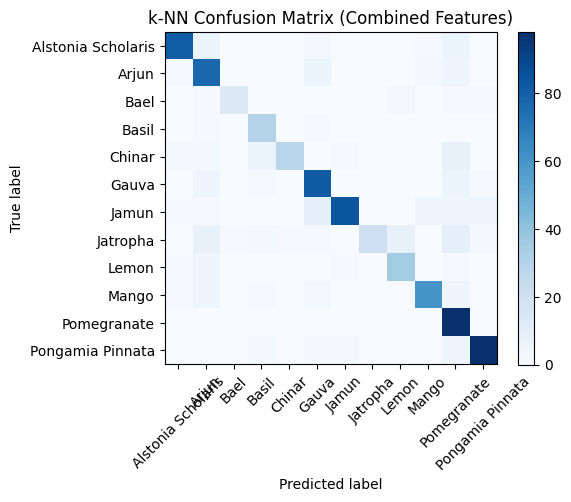

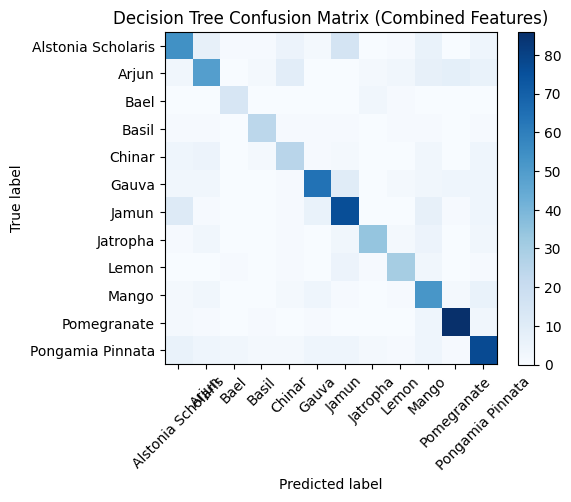

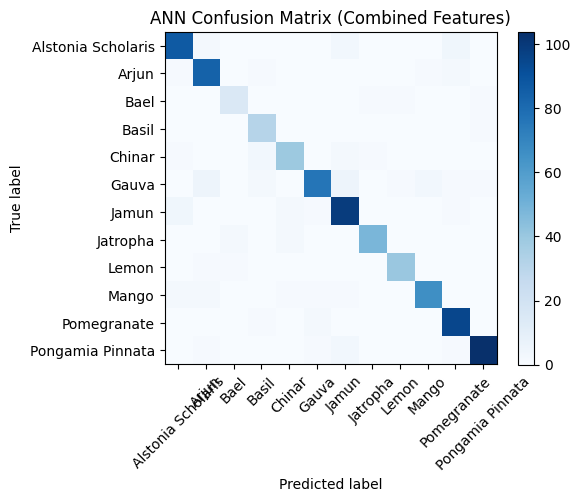

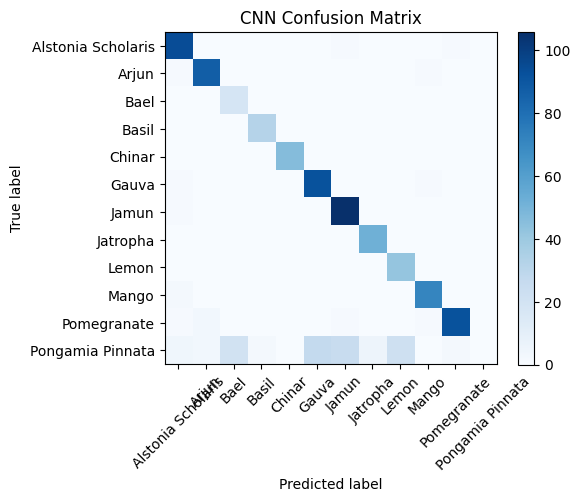

In [13]:
# 9. Plotting confusion matrices
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(class_labels))
    plt.xticks(ticks, class_labels, rotation=45)
    plt.yticks(ticks, class_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_cm(y_test, knn_pred, 'k-NN Confusion Matrix (Combined Features)')
plot_cm(y_test, dt_pred, 'Decision Tree Confusion Matrix (Combined Features)')
plot_cm(y_test, ann_pred, 'ANN Confusion Matrix (Combined Features)')
plot_cm(y_cnn_test, cnn_pred, 'CNN Confusion Matrix')

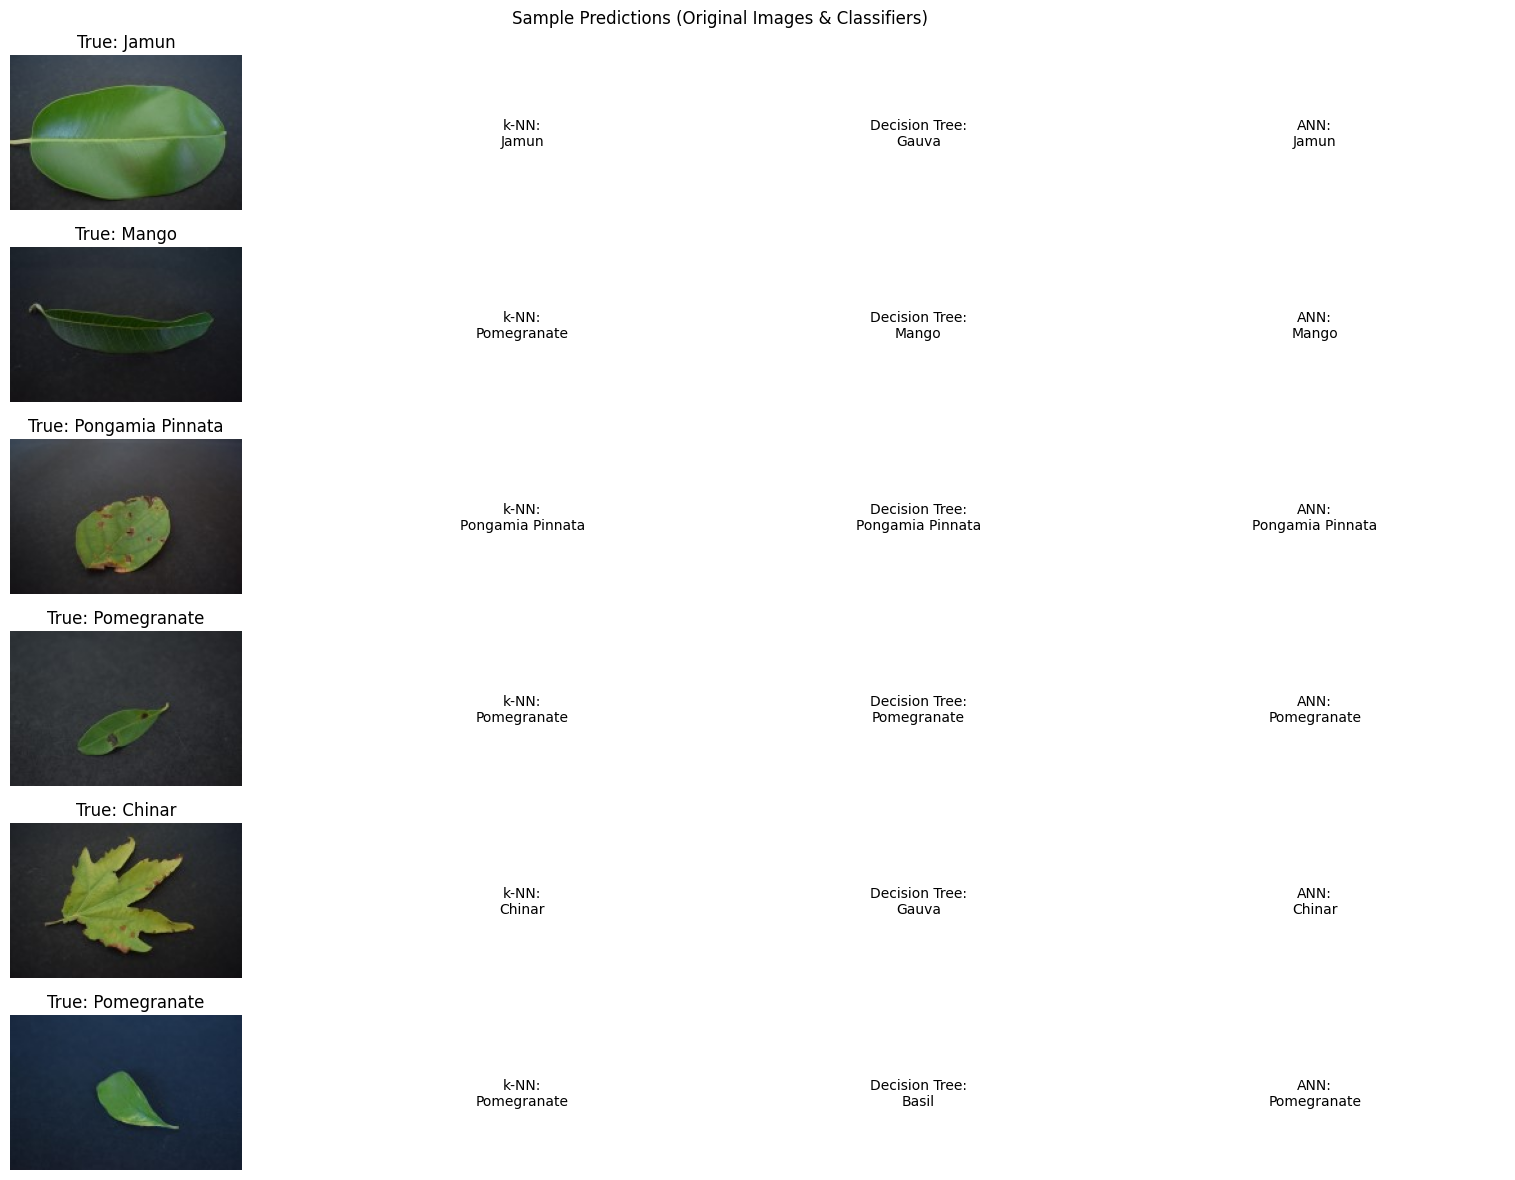

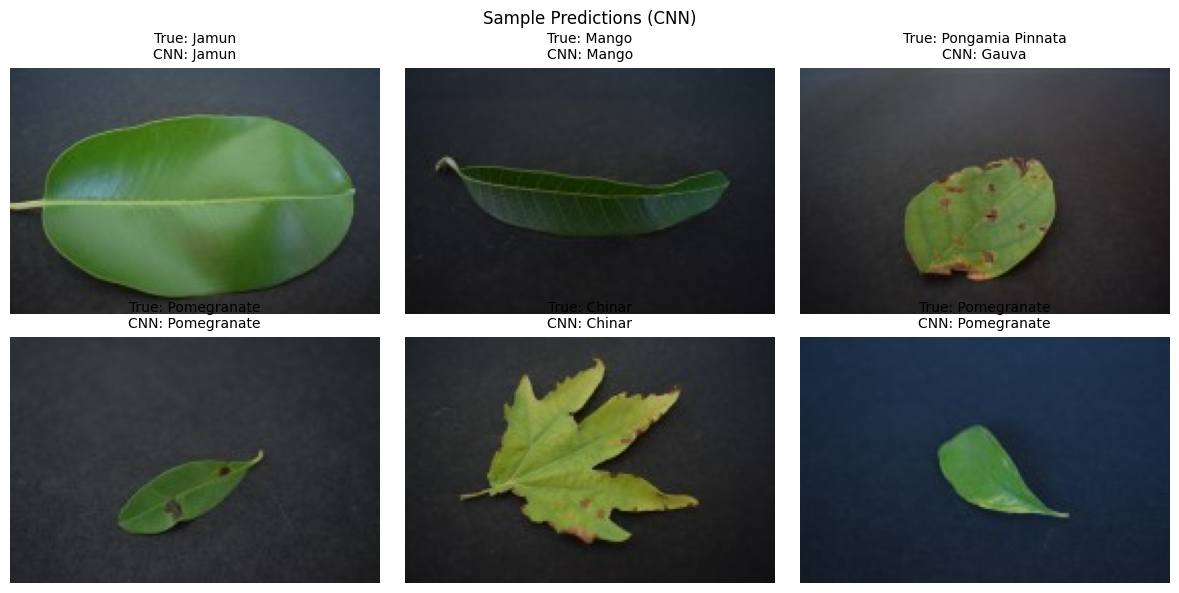

In [14]:
# 10. Sample predictions visualization for all classifiers

plt.figure(figsize=(16, 12))
num_samples = 6  # Number of samples to show
for i in range(num_samples):
    ax = plt.subplot(num_samples, 4, 4*i + 1)
    ax.imshow(cv2.cvtColor(img_test[i], cv2.COLOR_BGR2RGB))
    ax.set_title(f"True: {le.inverse_transform([y_test[i]])[0]}")
    ax.axis('off')

    ax = plt.subplot(num_samples, 4, 4*i + 2)
    ax.text(0.5, 0.5, f"k-NN:\n{le.inverse_transform([knn_pred[i]])[0]}",
            ha='center', va='center', fontsize=10)
    ax.axis('off')

    ax = plt.subplot(num_samples, 4, 4*i + 3)
    ax.text(0.5, 0.5, f"Decision Tree:\n{le.inverse_transform([dt_pred[i]])[0]}",
            ha='center', va='center', fontsize=10)
    ax.axis('off')

    ax = plt.subplot(num_samples, 4, 4*i + 4)
    ax.text(0.5, 0.5, f"ANN:\n{le.inverse_transform([ann_pred[i]])[0]}",
            ha='center', va='center', fontsize=10)
    ax.axis('off')

plt.suptitle('Sample Predictions (Original Images & Classifiers)')
plt.tight_layout()
plt.show()

# CNN sample predictions with images (since CNN uses raw images directly)

plt.figure(figsize=(12, 6))
for i in range(num_samples):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(cv2.cvtColor(img_test[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')
    true_lbl = le.inverse_transform([y_test[i]])[0]
    cnn_lbl = le.inverse_transform([cnn_pred[i]])[0]
    ax.set_title(f"True: {true_lbl}\nCNN: {cnn_lbl}", fontsize=10)
plt.suptitle('Sample Predictions (CNN)')
plt.tight_layout()
plt.show()